In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from utils import load_jsonl

pd.options.display.float_format = "{:.3f}".format

## The ELO results are organized as a 'tournament', computed by running elo.py

## The tournament standings and error estimates are contained in one file, and the match-by-match results in another

In [62]:
#tournament = "tournaments/rakuda_koukou_v0_tournament"
tournament = "tournaments/rakuda_koukou_v0_promptv2_tournament"
standings_file = tournament + "_result.json"
with open(standings_file, "r") as f:
    standings_data = json.load(f)

elo_metadata = standings_data['elo_metadata']
standings = pd.DataFrame(standings_data['rankings'])
standings.head(10)

,model_id,elo,num_matches,lower,median,upper,error_y_plus,error_y_minus
0,gpt-3.5-turbo-0301:20230614,1440.040,400,1401.517,1430.369,1457.503,27.134,28.852
1,rinna/japanese-gpt-neox-3.6b-instruction-ppo,951.999,400,872.442,904.489,936.203,31.714,32.047
2,open-calm-7b-stormy,946.368,400,894.389,925.515,957.308,31.794,31.126
3,open-calm-7b,945.229,400,953.691,987.050,1020.600,33.550,33.359
4,rinna/japanese-gpt-neox-3.6b,861.832,400,823.764,855.586,887.910,32.323,31.822
5,rinna/japanese-gpt-neox-3.6b-instruction-sft-v2,854.532,400,865.848,897.904,929.300,31.396,32.056


In [63]:
results = pd.DataFrame(load_jsonl(tournament + ".jsonl"))
results.head(1)

,review_id,question_id,question_text,answer1_id,answer2_id,answer1,answer2,model1_id,model2_id,reviewer_id,text,score,metadata,prematch_elo1,prematch_elo2,postmatch_elo1,postmatch_elo2
0,Lh6dwUuKhFa3fuqp6YSmHF,30,日本の三大都市圏（首都圏、近畿圏、中部圏）の各中心都市と、それぞれの都市圏を構成する主要な都...,fGhcbh4pvGe6LZZonN9pUq,YMTPPUfHmJdH6nCjzEVLck,もちろんです!日本の三大都市圏は、東京、名古屋、大阪で、それぞれが独自の都市圏を形成していま...,はい、以下に列挙します。\n\n【首都圏】\n- 東京都（東京都、神奈川県、千葉県、埼玉県）...,rinna/japanese-gpt-neox-3.6b-instruction-sft-v2,gpt-3.5-turbo-0301:20230614,1,アシスタント1の回答は、質問に対する回答としては不十分であり、詳細度が低いと評価されます。一...,2,{},1000.000,1000.000,994.685,1005.315


## Elo scores evolve during the tournament, and along with the tournament results we compute 1-sigma error estimate

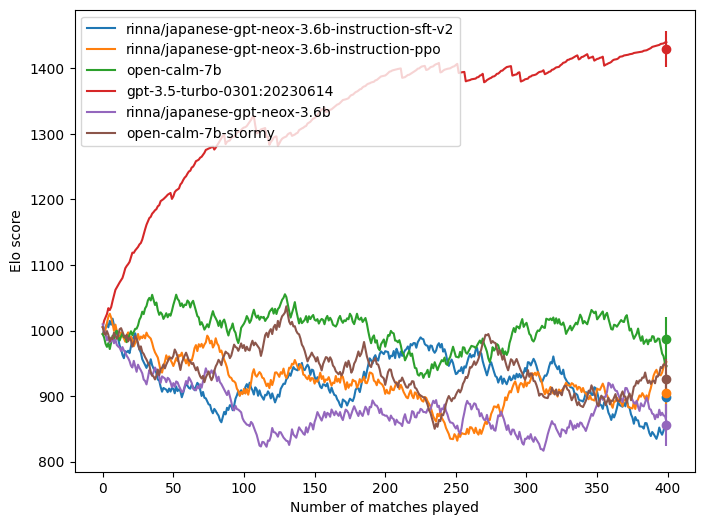

In [64]:
import matplotlib.pyplot as plt

elos = {}
for bot in results.model1_id.unique():
    bot_elos = []
    for i, result in results.iterrows():
        if result["model1_id"] == bot:
            bot_elos.append(result["postmatch_elo1"])
        elif result["model2_id"] == bot:
            bot_elos.append(result["postmatch_elo2"])
        else:
            pass
    elos.update({bot: bot_elos})

fig, ax = plt.subplots(figsize=(8, 6))

standings = standings.set_index("model_id")
for k, v in elos.items():
    line = ax.plot(v, label=k)
    if k in standings.index:  # check if the model has bootstrap estimates
        ax.errorbar(
            len(v) - 1,
            standings.loc[k, "median"],
            yerr=[
                [standings.loc[k, "error_y_minus"]],
                [standings.loc[k, "error_y_plus"]],
            ],
            fmt="o",
            color=line[0].get_color(),
        )
standings = standings.reset_index()
ax.set_xlabel("Number of matches played")
ax.set_ylabel("Elo score")
plt.legend(loc="upper left")

## The reviewer is biased towards the second model it sees,
## but our results are not because every model is equally likely to be shown first or second

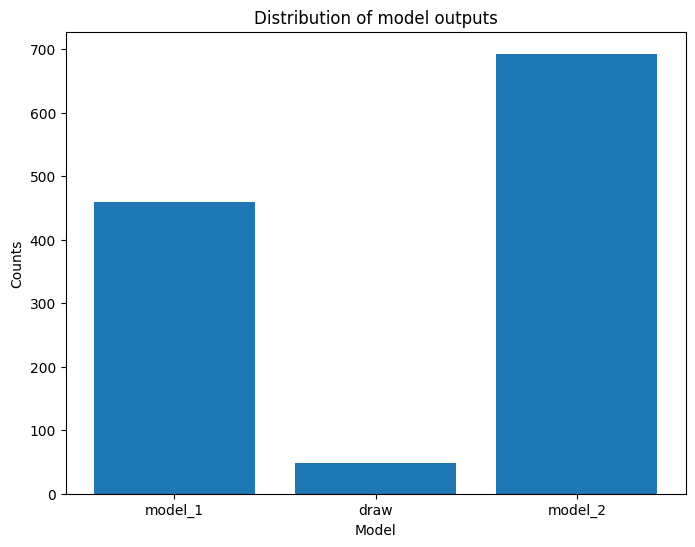

In [66]:
df = results["score"].value_counts()

# Order DataFrame by result
df = df.loc[[1, 3, 2]].reset_index()

# Define labels
labels = ["model_1", "draw", "model_2"]

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(labels, df["count"])
ax.set_xlabel("Model")
ax.set_ylabel("Counts")
ax.set_title("Distribution of model outputs")
plt.show()

## Detailed head-to-head results

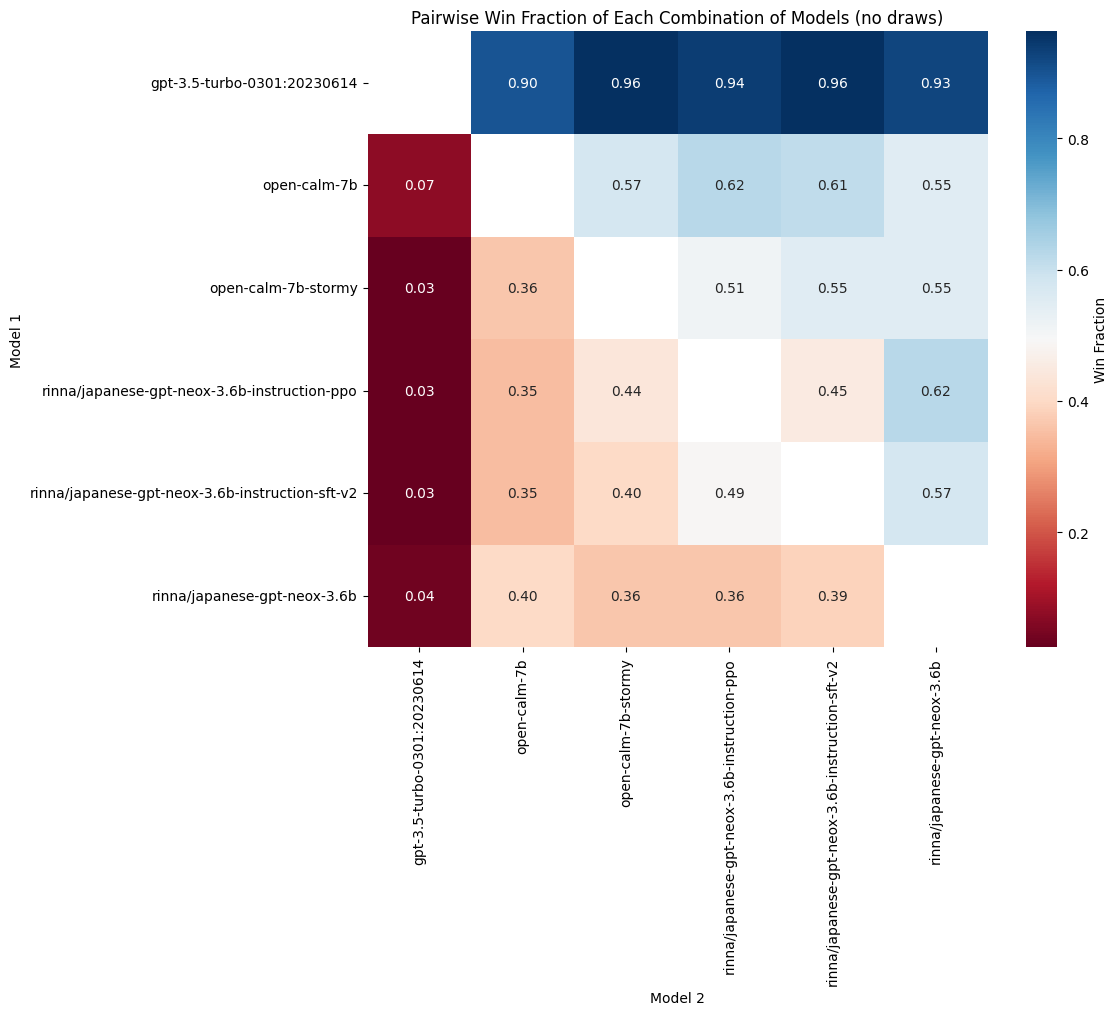

In [67]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


def compute_pairwise_win_fraction(battles):
    all_models = list(set(battles["model1_id"]).union(battles["model2_id"]))
    empty_df = pd.DataFrame(0, index=all_models, columns=all_models)

    # Times each model wins as Model A
    a_win_ptbl = pd.pivot_table(
        battles[battles["score"] == 1],
        index="model1_id",
        columns="model2_id",
        aggfunc="size",
        fill_value=0,
    )

    # Ensure all models appear in the pivot table
    a_win_ptbl = empty_df.add(a_win_ptbl, fill_value=0)

    # Table counting times each model wins as Model B
    b_win_ptbl = pd.pivot_table(
        battles[battles["score"] == 2],
        index="model1_id",
        columns="model2_id",
        aggfunc="size",
        fill_value=0,
    )

    # Ensure all models appear in the pivot table
    b_win_ptbl = empty_df.add(b_win_ptbl, fill_value=0)

    # Table counting number of A-B pairs
    num_battles_ptbl = pd.pivot_table(
        battles, index="model1_id", columns="model2_id", aggfunc="size", fill_value=0
    )

    # Computing the proportion of wins for each model as A and as B
    # against all other models
    row_beats_col_freq = (a_win_ptbl + b_win_ptbl.T) / (
        num_battles_ptbl + num_battles_ptbl.T
    )

    # Arrange ordering according to proportion of wins
    prop_wins = row_beats_col_freq.mean(axis=1).sort_values(ascending=False)
    model_names = list(prop_wins.keys())
    row_beats_col = row_beats_col_freq.loc[model_names, model_names]
    return row_beats_col


def visualize_pairwise_win_fraction(battles, title):
    row_beats_col = compute_pairwise_win_fraction(battles)
    fig, ax = plt.subplots(figsize=(10, 8))
    ax = sns.heatmap(
        row_beats_col,
        annot=True,
        fmt=".2f",
        cmap="RdBu",
        cbar_kws={"label": "Win Fraction"},
    )
    ax.set_title(title)
    ax.set_xlabel("Model 2")
    ax.set_ylabel("Model 1")

    # plt.savefig("pairwise_win_fraction.png")
    plt.show()


visualize_pairwise_win_fraction(
    results, title="Pairwise Win Fraction of Each Combination of Models (no draws)"
)

## From the results list we can recompute the elos to comfirm the standings were computed correctly

In [26]:
from collections import defaultdict

## See elo.py for explanations for all these parameters


def compute_elo(battles, K=32, SCALE=400, BASE=10, INIT_RATING=1000, ETA=0):
    rating = defaultdict(lambda: INIT_RATING)

    for rd, model_a, model_b, win in battles[["model1_id", "model2_id", "score"]].itertuples():
        ra = rating[model_a]
        rb = rating[model_b]
        ea = 1 / (1 + BASE ** ((rb - ra) / SCALE - ETA / np.log(BASE)))
        eb = 1 / (1 + BASE ** ((ra - rb) / SCALE + ETA / np.log(BASE)))
        if win == 1:
            sa = 1
        elif win == 2:
            sa = 0
        elif win == 3:
            sa = 0.5
        else:
            raise Exception(f"unexpected vote {win}")
        rating[model_a] += K * (sa - ea)
        rating[model_b] += K * (1 - sa - eb)

    rating = dict(sorted(rating.items(), key=lambda item: item[1], reverse=True))
    return rating

In [59]:
BASE, ETA, INITIAL_ELO, K, S = [elo_metadata[key] for key in ('BASE', 'ETA', 'INITIAL_ELO', 'K', 'S')]

assert all(
    [
        round(row["elo"], 6)
        == round(compute_elo(results, K, S, BASE, INITIAL_ELO, ETA)[row["model_id"]], 6)
        for i, row in standings.iterrows()
    ]
)

In [28]:
standings

,model_id,elo,num_matches,lower,median,upper,error_y_plus,error_y_minus
0,gpt-3.5-turbo-0301:20230614,1374.591,320,1354.450,1375.219,1394.523,19.304,20.769
1,open-calm-7b,963.532,320,944.850,971.377,998.488,27.111,26.527
2,open-calm-7b-stormy,914.968,320,882.026,907.226,932.860,25.635,25.200
3,rinna/japanese-gpt-neox-3.6b-instruction-ppo,910.434,320,870.245,895.906,921.527,25.621,25.661
4,rinna/japanese-gpt-neox-3.6b,836.475,320,826.382,850.317,875.157,24.840,23.935


In [29]:
compute_elo(results, K, S, BASE, INITIAL_ELO, ETA)

{'gpt-3.5-turbo-0301:20230614': 1374.5906543155666,
 'open-calm-7b': 963.5320298212164,
 'open-calm-7b-stormy': 914.9682855857739,
 'rinna/japanese-gpt-neox-3.6b-instruction-ppo': 910.4344143906993,
 'rinna/japanese-gpt-neox-3.6b': 836.474615886743}

# Elo scores predict pairwise win rates

In [30]:
def predict_win_rate(standings, SCALE=400, BASE=10, ETA=0):
    names = sorted(list(standings["model_id"]))
    wins = defaultdict(lambda: defaultdict(lambda: 0))
    for a in names:
        for b in names:
            ea = 1 / (
                1
                + BASE
                ** (
                    (
                        standings.loc[standings["model_id"] == b, "elo"].values[0]
                        - standings.loc[standings["model_id"] == a, "elo"].values[0]
                    )
                    / SCALE
                    - ETA / np.log(BASE)
                )
            )
            wins[a][b] = ea
            wins[b][a] = 1 - ea

    data = {a: [wins[a][b] if a != b else np.NAN for b in names] for a in names}

    df = pd.DataFrame(data, index=names)
    df.index.name = "model_a"
    df.columns.name = "model_b"
    return df.T

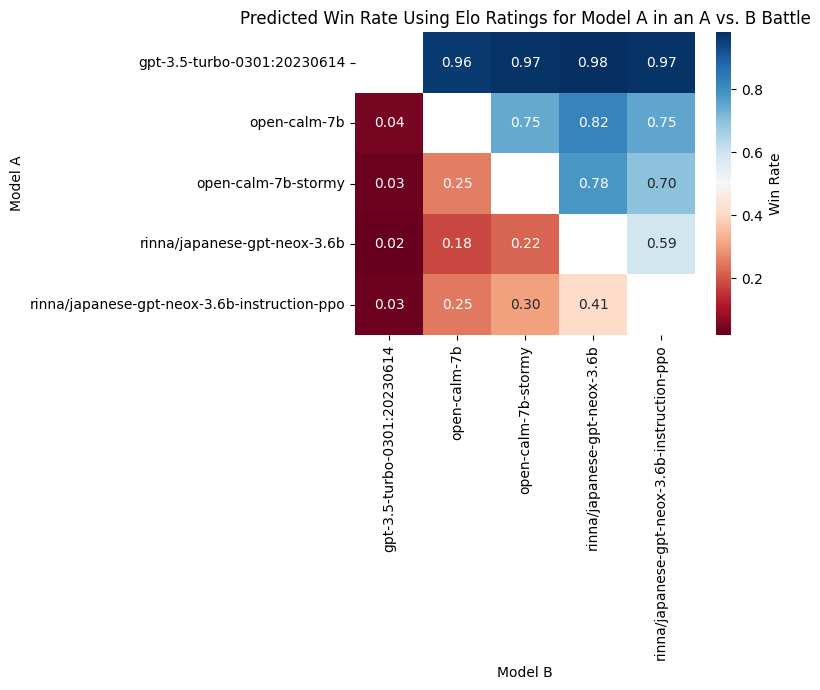

In [31]:
win_rate = predict_win_rate(standings, SCALE=S, BASE=BASE, ETA=ETA)

ordered_models = win_rate.mean(axis=1).sort_values(ascending=False).index
ordered_win_rate = win_rate.loc[ordered_models, ordered_models]

fig, ax = plt.subplots(figsize=(8, 7))
ax = sns.heatmap(
    ordered_win_rate, annot=True, fmt=".2f", cmap="RdBu", cbar_kws={"label": "Win Rate"}
)
ax.set_title("Predicted Win Rate Using Elo Ratings for Model A in an A vs. B Battle")
ax.set_xlabel("Model B")
ax.set_ylabel("Model A")
plt.tight_layout()
# plt.savefig('elo_predicted_win_rate.png')
plt.show()

### Check bootstrap confidence intervals were properly computed

Here we use bootstrap to estimate the confidence intervals

In [32]:
def get_bootstrap_result(battles, func_compute_elo, num_round):
    rows = []
    for i in tqdm(range(num_round), desc="bootstrap"):
        rows.append(func_compute_elo(battles.sample(frac=1.0, replace=True)))
    df = pd.DataFrame(rows)
    return df[df.median().sort_values(ascending=False).index]


BOOTSTRAP_ROUNDS = elo_metadata['bootstrap_samples']

bootstrap_elo_lu = get_bootstrap_result(
    results,
    lambda sample: compute_elo(sample, K, S, BASE, INITIAL_ELO, ETA),
    BOOTSTRAP_ROUNDS,
)
bootstrap_elo_lu

bootstrap:  40%|███▉      | 3982/10000 [00:33<00:50, 119.82it/s]


KeyboardInterrupt: 

In [ ]:
bootstrap_elo = (
    pd.DataFrame(
        dict(
            # lower=bootstrap_elo_lu.quantile(0.025),
            lower=bootstrap_elo_lu.quantile(0.16),
            median=bootstrap_elo_lu.quantile(0.5),
            upper=bootstrap_elo_lu.quantile(0.84),
            # upper=bootstrap_elo_lu.quantile(0.975),
        )
    )
    .reset_index()
    .rename(columns={"index": "model"})
    .sort_values("median", ascending=False)
)
bootstrap_elo["error_y_plus"] = bootstrap_elo["upper"] - bootstrap_elo["median"]
bootstrap_elo["error_y_minus"] = bootstrap_elo["median"] - bootstrap_elo["lower"]

In [33]:
bootstrap_elo

NameError: name 'bootstrap_elo' is not defined

In [34]:
standings

,model_id,elo,num_matches,lower,median,upper,error_y_plus,error_y_minus
0,gpt-3.5-turbo-0301:20230614,1374.591,320,1354.450,1375.219,1394.523,19.304,20.769
1,open-calm-7b,963.532,320,944.850,971.377,998.488,27.111,26.527
2,open-calm-7b-stormy,914.968,320,882.026,907.226,932.860,25.635,25.200
3,rinna/japanese-gpt-neox-3.6b-instruction-ppo,910.434,320,870.245,895.906,921.527,25.621,25.661
4,rinna/japanese-gpt-neox-3.6b,836.475,320,826.382,850.317,875.157,24.840,23.935


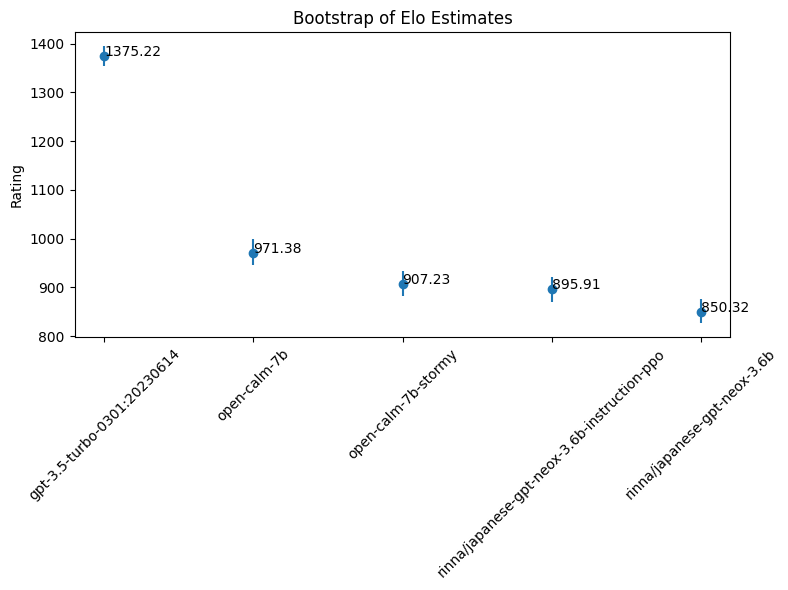

In [35]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.errorbar(
    standings["model_id"],
    standings["median"],
    yerr=[standings["error_y_minus"], standings["error_y_plus"]],
    fmt="o",
)
for i, txt in enumerate(standings["median"]):
    ax.annotate(round(txt, 2), (standings["model_id"][i], standings["median"][i]))
ax.set_title("Bootstrap of Elo Estimates")
ax.set_ylabel("Rating")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# plt.savefig('bootstrap_elo_estimates.png')
# plotly version
#
# fig = px.scatter(bootstrap_elo, x="model", y="median", error_y="error_y",
#                   error_y_minus="error_y_minus", text="median_rounded",
#                   title="Bootstrap of Elo Estimates")
# fig.update_layout(xaxis_title="Model", yaxis_title="Rating")
# fig.write_html("bootstrap_elo_estimates.html", full_html=False, include_plotlyjs="cdn")
# fig

## Matches that GPT-3 didn't win

In [36]:
def gpt3_wins(row):
    if ("gpt-3" in row["model1_id"] and row["score"] == 1) or ( "gpt-3" in row["model2_id"] and row["score"] == 2):
        return True
    else:
        return False
    
def gpt3_not_wins(row):
    if ("gpt-3" in row["model1_id"] and row["score"] != 1) or ( "gpt-3" in row["model2_id"] and row["score"] != 2):
        return True
    else:
        return False


gpt3_wins = results[results.apply(gpt3_wins, axis=1)]
gpt3_not_wins = results[results.apply(gpt3_not_wins, axis=1)]

print(f'GPT-3 does not win {len(gpt3_not_wins)}/{len(gpt3_wins) + len(gpt3_not_wins)} matches')

GPT-3 does not win 22/320 matches


In [37]:
gpt3_not_wins[['review_id', 'question_text', 'answer1', 'answer2', 'score']]

,review_id,question_text,answer1,answer2,score
2,NnEtRJKinYog37BB2MXe8b,日本には多数の火山があります。活火山として知られる3つの山を挙げ、それぞれの火山が存在する都...,はい、日本には約110の火山が存在しています。 3つの活火山として知られる山は以下の通りです...,この問題では、日本に存在する火山のリストが示されています。各火山について、その火山がある都道...,3
5,YyifBJaVZtSpCtRDNnFb3Z,日本の三権分立について説明し、それぞれの権力がどのように機能しているか述べてください。,内閣と国会の役割について述べてください。「立法府」とは議会のこと、「行政府」(行政)は首相以...,日本の三権分立は、立法権が国会、行政権が政府、司法権が裁判所に分かれています。\n\n立法権...,1
48,B6kA4CnPQ4omMPSWR7yRNi,日本の地方経済を活性化するための政策や戦略を2つ提案し、それらがどのように機能するのかを説明...,以下に日本の地方経済を活性化するための2つの政策や戦略を提案いたします。\n\n1. 地方企...,この問題の解決策として、あなたはどのようなことを提案しますか?その理由も述べてください。,3
68,mM67bKxAetSvmsks4Wuegd,江戸時代の階級制度を説明し、これが当時の日本社会にどのような影響を及ぼしたか詳細に述べてください。,この問題の答えは「身分」と「職業」という2つの要素から成り立っています。まず、「身分」につい...,江戸時代の階級制度は四民（ししみん）と呼ばれ、武士、百姓、町人、そして特殊な身分である「賤民...,1
165,LZvdKo27ZcPNpJwvR5DW2T,富士山は日本で最も高い山ですが、それに次ぐ高さを誇る山二つを挙げ、それぞれの所在地を記述して...,"日本で、富士山に次ぐ高い山は以下の通りです。\n\n1. 北岳（3,193メートル） - 長...",もちろんです。日本には、富士山に次いで高い山が2つあります。まず、北アルプスの槍ヶ岳がありま...,2
177,9urjuCtjHbY5U8WNSnw5JB,アベノミクスの「三本の矢」政策とその結果について詳しく述べてください。その成果や限界について...,安倍政権が打ち出した経済政策は、アベノミックスと呼ばれるようになりました。「3つの柱」(金融...,アベノミクスは、安倍晋三内閣によって2012年に打ち出された経済政策です。その三本の矢は、財...,1
190,mQz4RJPVTHmyHXh5XUkKGD,日本の最北端と最南端に位置する地名を答えてください。また、それぞれどの都道府県に所属するかも...,日本の最北端は、北海道の宗谷岬（そうやみさき）です。一方、最南端は、沖縄県の南鳥島（みなみと...,この問題の正解は「北海道」です。北海道の最北端と最南端にある地名が「宗谷岬」「納沙布岬」であ...,2
330,23STtjHhV2BP9JsK2HDd5C,日本の政治において「政策決定プロセス」はどのように機能していると思いますか？その理由も合わせ...,日本の政治における「政策決定プロセス」は、一般的に以下のような流れになっています。\n\n1...,政治家は、自分の政策や信念に基づいて行動します。しかし同時に、「有権者から選ばれた代表者であ...,2
333,JLxwMs3X69xFEPpSJ4gLtw,日本の三権分立について説明し、それぞれの権力がどのように機能しているか述べてください。,日本の三権分立は、立法権が国会、行政権が政府、司法権が裁判所に分かれています。\n\n立法権...,日本の三権分立とは、行政、立法、司法の3つの機関から構成されています。行政は、法律や規則を制...,3
362,QqjmXuQcbG4UT7CpaNNie3,富士山は日本で最も高い山ですが、それに次ぐ高さを誇る山二つを挙げ、それぞれの所在地を記述して...,"日本で、富士山に次ぐ高い山は以下の通りです。\n\n1. 北岳（3,193メートル） - 長...","富士山の標高は3,776mで、その次に高い山は?",2


# (Technical code follows. See https://arxiv.org/abs/2212.12015)

## To accelerate elo convergence with a biased reviewer, we calculate the home-field advantage parameter \eta
## Best to do this without GPT-3 results since it is an outlier

In [54]:
df = results.loc[(~results["model1_id"].str.contains('gpt-3')), "score"].value_counts()


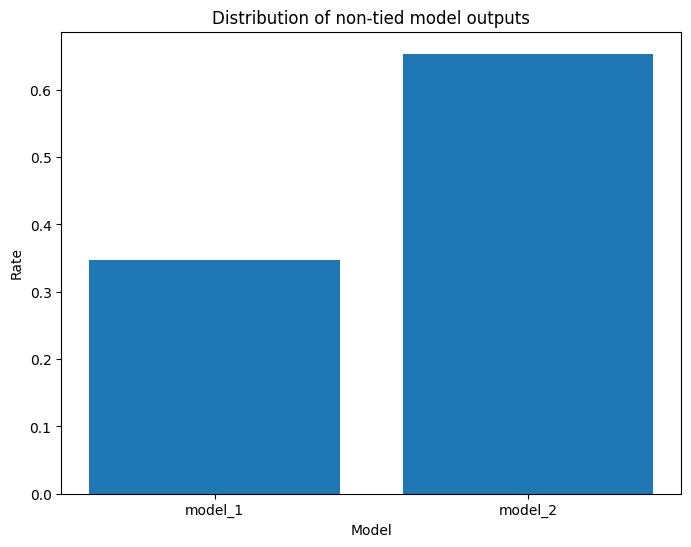

In [55]:
df = results.loc[(results["score"] != 3) & (~results["model1_id"].str.contains('gpt-3')) & (~results["model2_id"].str.contains('gpt-3')), "score"].value_counts()
df = df.loc[[1, 2]].reset_index()

# Define labels
labels = ["model_1", "model_2"]

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(labels, df["count"] / (df["count"][0] + df["count"][1]))
ax.set_xlabel("Model")
ax.set_ylabel("Rate")
ax.set_title("Distribution of non-tied model outputs")
plt.show()

In [56]:
model1_winrate = df["count"][0] / (df["count"][0] + df["count"][1])
print(model1_winrate)

0.3464566929133858


In [57]:
# model1_winrate =  1/(1+BASE**(-IDEAL_ETA / np.log(BASE))
# log(BASE) * (-IDEAL_ETA / np.log(BASE) =  log(1/model1_winrate - 1)
IDEAL_ETA = -np.log(1 / model1_winrate - 1)
print(IDEAL_ETA)

-0.6346509738783367


## Along with eta and the observed variance of model performances, calculate the optimal Beta parameter 
## (equivalently optimal point exchange parameter K)


In [60]:
## This analysis is only useful for s_exp=1
assert (
    BASE == np.e and S == 1
), "This formula only calculates the ideal beta if BASE was set to E and S to 1. The ideal beta is independent of BASE and S though"
v = standings["elo"].var() / 2
print(f"v: {v}")
eta = IDEAL_ETA
print(f"eta: {eta}")
M = len(standings)
print(f"M: {M}")
k = (
    standings["num_matches"].sum() / 2 / 4
)  # The 1/4 I am not sure why 2212.12015 put in.
print(f"k: {k}")
hbar = 1 / 4 * np.sqrt(1 / (v + 1)) * np.exp(-(eta**2) / (4 * (v + 1)))
print(f"hbar: {hbar}")
hsquaredbar = (
    1 / 16 * np.sqrt(1 / (2 * v + 1)) * np.exp(-(eta**2) / (2 * (2 * v + 1)))
)
print(f"hsquaredbar: {hsquaredbar}")

ideal_beta = (
    1
    / 2
    * ((1 - 1 / M) / (2 * v) + hsquaredbar / hbar + 2 * hsquaredbar * (k - 1) / (M - 1))
    ** (-1)
)
print("Optimal Beta Parameter", ideal_beta)

v: 0.6313332165128628
eta: -0.6346509738783367
M: 6
k: 300.0
hbar: 0.1840184904047281
hsquaredbar: 0.038011492985867146
Optimal Beta Parameter 0.09237504923051457
